# Network features and questions 

Here we aim to use network science techniques to answer our questions about politics and voting patterns. The network construction was realized in the two previous notebooks. 

In [46]:
import pandas as pd
import numpy as np
import networkx as nx
from networkx.algorithms import community 

import matplotlib 
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import seaborn as sns

import time
from tqdm.notebook import trange, tqdm
import json

import sys  
sys.path.insert(0, '../pyscripts/')

from prepare_adjacency_matrix import GraphConstruction

## Notebook settings

Below we define some things important all over the notebook. 

In [12]:
party_color = {'PT': '#CC0000', 'PSL': '#008000', 'PL': '#0F0073', 'PP': '#7DC9FF',
               'PSDB': '#0080FF', 'PSD':'#FFA500', 'MDB': '#30914D', 'REPUBLICANOS': '#005DAA', 
               'PSB': '#FFCC00', 'DEM': '#8CC63E', 'PDT': '#FF0000', 'SOLIDARIEDADE': '#FF9C2B', 
               'PROS': '#FF5460', 'PODE': '#2DA933', 'PTB': '#7B7B7B', 'PSC': '#009118', 
               'PSOL': '#700000', 'PCdoB': '#A30000', 'CIDADANIA': '#EC008C', 'AVANTE': '#ED5F36', 
               'NOVO': '#FF4D00', 'PATRIOTA': '#00A29B', 'PV': '#006600', 'REDE': '#379E8D', 
               'S.PART.': '#DDDDDD', 'PR': '#0F0073', 'PRB': '#005DAA', 'PATRI': '#00A29B', 
               'PHS': 'black', 'PPS': '#EC008C', 'PPL': 'black', 'PRTB': 'black', 'PRP': 'black',
               'PMDB': '#30914D', 'PP**': "#7DC9FF", 'SDD': '#FF9C2B', 'PMN': 'black', 'PTdoB': '#ED5F36',
               'PTC': 'black', 'PFL': '#8CC63E', 'PL*': '#0F0073', 'PEN': '#00A29B','PSDC': 'black'
              }

region_color = {'Norte': '#08FB74', 'Nordeste': '#FA9A14', 'Sudeste': '#6E30FF', 
                'Sul': '#E61C38', 'Centro-oeste': '#D7E307'}

sns.set()

palette = "#21593b"

We have prepared all the necessary data to help the construction in this notebook. 

In [25]:
graphConstrutor = GraphConstruction()

legislature = 56
adjacency_matrix = graphConstrutor.import_adjacency_matrix(legislature, 'same', 'same')
G = graphConstrutor.build_graph_threshold(adjacency_matrix, threshold = 0.95, legislature = legislature)

Below we see the first metric that ponders each voting with if the deputies agree, and 0 otherwise. 

In [26]:
# Removing the zero-degree deputies. 
remove = [node for node,degree in dict(G.degree()).items() if degree < 1]
G.remove_nodes_from(remove)

# For Networkx, it is better to work with consecutive integers. For that, we do this simple transformation. 
G = nx.convert_node_labels_to_integers(G, first_label = 0, ordering = 'default', label_attribute = 'id')

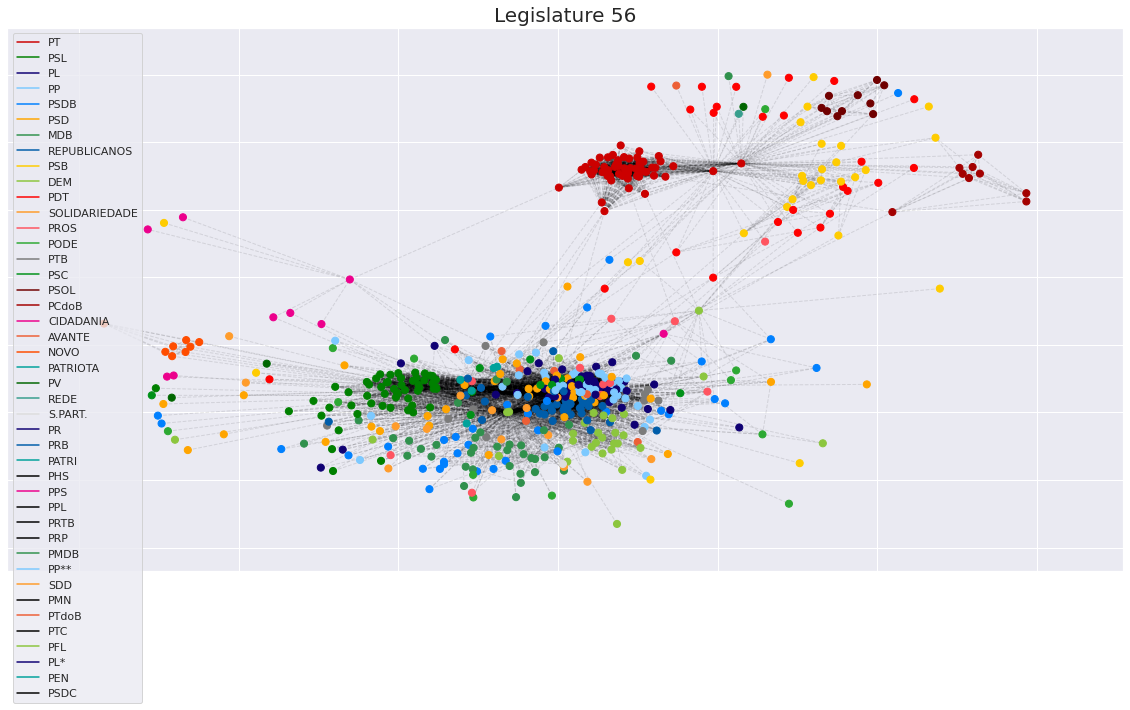

In [16]:
# Setting up colors 
colors = [party_color[G.nodes[n]['party']] for n in G.nodes]

fig, ax = plt.subplots(figsize=(20,10))

pos = nx.spring_layout(G)
nx.draw_networkx_nodes(G, pos=pos, node_size = 50, node_color = colors, ax = ax)
nx.draw_networkx_edges(G, pos=pos, edge_color='black', style='dashed',alpha =0.1, ax = ax)

for label,color in party_color.items():
    ax.plot([0],[0], color=color, label=label)

ax.legend()
plt.title('Legislature 56', fontsize = 20)
plt.show()

# Main features of the network

Here we present the main features of the deputies' network.

In [17]:
degree_freq = np.array(nx.degree_histogram(G))[1:]
degrees = np.array(range(1,len(degree_freq)+1))

com_distribution = degree_freq[::-1].cumsum()[::-1]

#degrees = degrees[np.where(degree_freq != 0)]
#degree_freq = degree_freq[np.where(degree_freq != 0)]

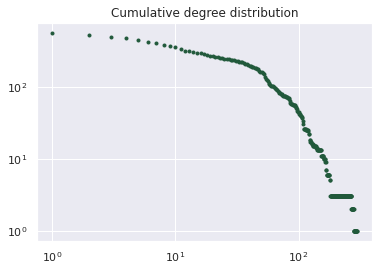

In [18]:
plt.scatter(degrees, com_distribution, marker = '.', color = palette)
plt.xscale('log')
plt.yscale('log')
plt.title('Cumulative degree distribution')
plt.show()

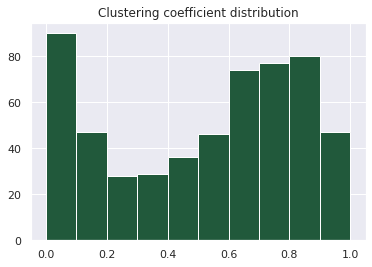

In [20]:
plt.hist(nx.clustering(G).values(), color = palette)
plt.title('Clustering coefficient distribution')
plt.show()

In [21]:
nx.transitivity(G)

0.493601808686695

## Communities

Using the concept of modularity, we can use the greedy algorithm to obtain subgraphs forming communities. 

In [125]:
communities = community.greedy_modularity_communities(G, resolution = 1.0)
node_belonging = {node: v for v in range(len(communities)) for node in communities[v]}
nx.set_node_attributes(G, node_belonging, name = 'community')  

In [129]:
# Picking the colors for the communities 
def pick_colors(n, palette = 'hsv'): 
    cmap = cm.get_cmap(palette, n)
    colors = {i: matplotlib.colors.rgb2hex(cmap(i)[:3]) for i in range(cmap.N)}
    return colors

community_colors = {0: '#3E5B8F', 
                    1: '#14D9F5', 
                    2: '#C23A23', 
                    3: '#F68151', 
                    4: '#FA3400',
                    5: '#235BC2',}

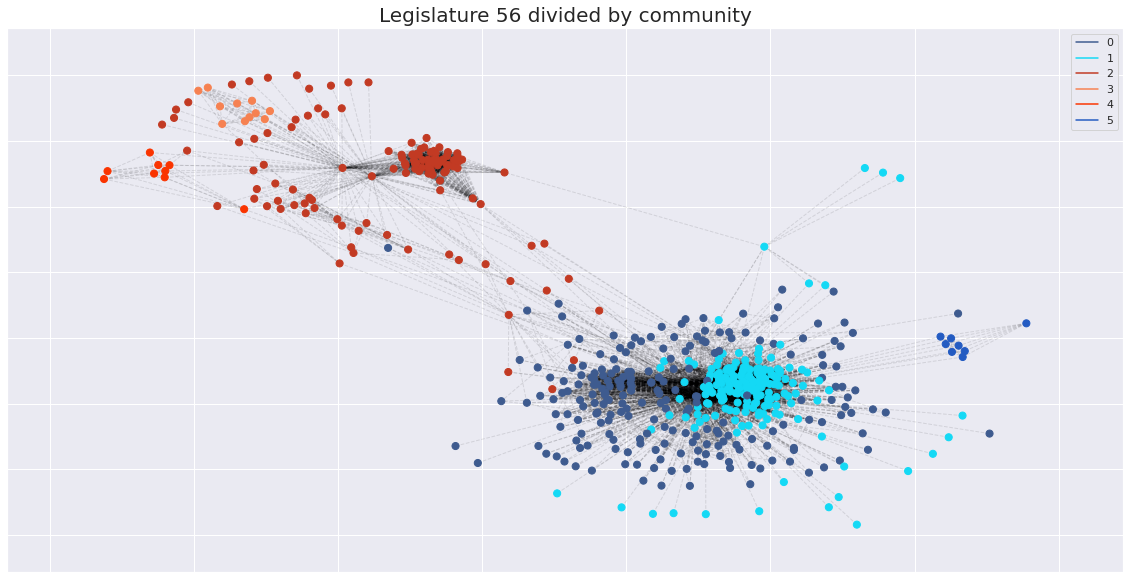

In [130]:
colors = [community_colors[G.nodes[n]['community']] for n in G.nodes]

fig, ax = plt.subplots(figsize=(20,10))

pos = nx.spring_layout(G)
nx.draw_networkx_nodes(G, pos=pos, node_size = 50, node_color = colors, ax = ax)
nx.draw_networkx_edges(G, pos=pos, edge_color='black', style='dashed',alpha =0.1, ax = ax)

for label,color in community_colors.items():
    ax.plot([0],[0], color=color, label=label)

ax.legend()
plt.title('Legislature 56 divided by community', fontsize = 20)
plt.show()

And if we want to know which parties are included in each community? 

In [170]:
parties_communities = [{} for i in range(len(communities))]
for node in G.nodes: 
    
    node_attributes = G.nodes[node]
    community = node_attributes['community']
    party = G.nodes[node]['party']
    try: 
        parties_communities[community][party] += 1
    except KeyError as e:
        parties_communities[community][party] = 1
        
parties_communities = pd.DataFrame({i: parties_communities[i] for i in range(len(communities))})#.fillna(0)
number_deputies = parties_communities.sum(axis = 1)
parties_communities = parties_communities.div(number_deputies, axis = 0)
parties_communities['deputies'] = number_deputies

Note that, excluding the zeros, if we take the maximum less minimum (except when the minimum is 1) from each party, we have a measure of how concentrated it is in one community. If the party has a lot of deputies in the same community, we will see a high measure: for instance PT, REDE, NOVO, PSOL, PCdoB, PSL, MDB, etc. That means that the community algorithm is well detecting these parties. Otherwise, some parties are more distributes, which means that the proportion of deputies in different communities differs little, indicanting a non-consistency considering the voting pattern. In special, PTB has the same number of deputies in two different communities. 

In [182]:
maximum = parties_communities[list(range(6))].max(axis=1) 
minimum = parties_communities[list(range(6))].min(axis=1)

(maximum - minimum*(minimum < 1)).sort_values()

PTB              0.000000
PROS             0.272727
PATRIOTA         0.333333
CIDADANIA        0.333333
PV               0.333333
AVANTE           0.375000
SOLIDARIEDADE    0.533333
PODE             0.583333
PSC              0.600000
PSDB             0.611111
PSD              0.625000
PP               0.627907
DEM              0.677419
REPUBLICANOS     0.684211
PSB              0.777778
PL               0.826087
PDT              0.846154
MDB              0.897436
PSL              0.963636
S.PART.          1.000000
PT               1.000000
REDE             1.000000
PSOL             1.000000
PCdoB            1.000000
NOVO             1.000000
dtype: float64